데이터 편향조사 원래대로 282 : 193으로 나눔

In [1]:
from preprocess import get_hinge_features
from preprocess import get_chain_code_features
from preprocess import preprocessing


import numpy as np
import pandas as pd
import cv2 
from PIL import Image
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score , roc_auc_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

In [2]:
y = np.load('new_y.npy')
x = np.load('new_cut_feature.npy')
x.shape , y.shape

((1900, 138), (1900,))

In [3]:
x_ar = []
x_en = []

y_ar = []
y_en = []
for i,v in enumerate(x):
    if i%4<2:
        x_ar.append(v)
        y_ar.append(y[i])
    else:
        x_en.append(v)
        y_en.append(y[i])
        
x_ar , y_ar , x_en , y_en= np.array(x_ar),np.array(y_ar),np.array(x_en),np.array(y_en)

print(x_ar.shape , x_en.shape , y_ar.shape , y_en.shape)

(950, 138) (950, 138) (950,) (950,)


In [4]:
#train test = 282 : 193

#아랍 데이터 나누기
x_train_ar , x_test_ar = x_ar[:564] , x_ar[564:]
y_train_ar , y_test_ar = y_ar[:564] , y_ar[564:]


#영어 데이터 나누기
x_train_en , x_test_en = x_en[:564] , x_en[564:]
y_train_en , y_test_en = y_en[:564] , y_en[564:]


#영아 + 아랍 데이터
x_train_all = np.concatenate((x_train_ar,x_train_en),axis=0)
x_test_all =  np.concatenate((x_test_ar,x_test_en),axis=0)

y_train_all = np.concatenate((y_train_ar,y_train_en),axis=0)
y_test_all = np.concatenate((y_test_ar,y_test_en),axis=0)

print(x_train_ar.shape , x_test_ar.shape)
print(y_train_ar.shape , y_test_ar.shape)

print(x_train_en.shape , x_test_en.shape)
print(y_train_en.shape , y_test_en.shape)
      
print(x_train_all.shape , x_test_all.shape)
print(y_train_all.shape , y_test_all.shape)

(564, 138) (386, 138)
(564,) (386,)
(564, 138) (386, 138)
(564,) (386,)
(1128, 138) (772, 138)
(1128,) (772,)


In [5]:
#Case마다 여기서 변경
train_x = x_train_all
test_x = x_test_all

train_y = y_train_all
test_y = y_test_all

cs = StandardScaler()
train_x = cs.fit_transform(train_x)
test_x = cs.transform(test_x)



#모두 False나와야 함
print(np.isnan(train_x).all(),np.isnan(test_x).all(),
      np.isnan(train_y).all(),np.isnan(test_y).all())
#모두 True 나와야 함
print(np.isfinite(train_x).all(),np.isfinite(test_x).all(),
      np.isfinite(train_y).all(),np.isfinite(test_y).all())

print(f'train data length: {len(train_x)} , {len(train_y)}')
print(f'train data length: {len(test_x)} , {len(test_y)}')

False False False False
True True True True
train data length: 1128 , 1128
train data length: 772 , 772


SVM

In [6]:
pd.set_option('display.max.colwidth', 100)

In [17]:
param_grid = {'kernel':['rbf'], 'C':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
              'gamma':['auto','scale',0.0001,0.0005,0.001,0.002,0,0.005,0.007,0.01,0.02,0.05]}

svm_clf = SVC(random_state=100,probability=True)
grid = GridSearchCV(svm_clf, param_grid=param_grid,scoring = 'neg_log_loss',verbose = 1,n_jobs =-1) 
grid.fit(train_x, train_y)

print(grid.best_score_,grid.best_params_)
print(pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score')[['rank_test_score','params','mean_test_score']][:5])

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  1.3min finished


-0.566087986091621 {'C': 1, 'gamma': 0.005, 'kernel': 'rbf'}
    rank_test_score                                     params  \
7                 1  {'C': 1, 'gamma': 0.005, 'kernel': 'rbf'}   
29                2  {'C': 3, 'gamma': 0.002, 'kernel': 'rbf'}   
19                3  {'C': 2, 'gamma': 0.005, 'kernel': 'rbf'}   
41                4  {'C': 4, 'gamma': 0.002, 'kernel': 'rbf'}   
17                5  {'C': 2, 'gamma': 0.002, 'kernel': 'rbf'}   

    mean_test_score  
7         -0.566088  
29        -0.566307  
19        -0.566392  
41        -0.566417  
17        -0.566875  


In [8]:
svm_pred = grid.best_estimator_.predict(test_x)
print('Accuracy:', accuracy_score(test_y, svm_pred)*100, '%')

Accuracy: 71.24352331606218 %


In [9]:
svm_pred

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,

In [20]:
from sklearn.metrics import log_loss
svm_pred = grid.best_estimator_.predict_proba(test_x)
print('log-loss:', log_loss(test_y, svm_pred))

log-loss: 0.5794815805049731


In [21]:
svm_pred

array([[0.40061287, 0.59938713],
       [0.03281045, 0.96718955],
       [0.97321968, 0.02678032],
       ...,
       [0.41240154, 0.58759846],
       [0.80706525, 0.19293475],
       [0.7614631 , 0.2385369 ]])

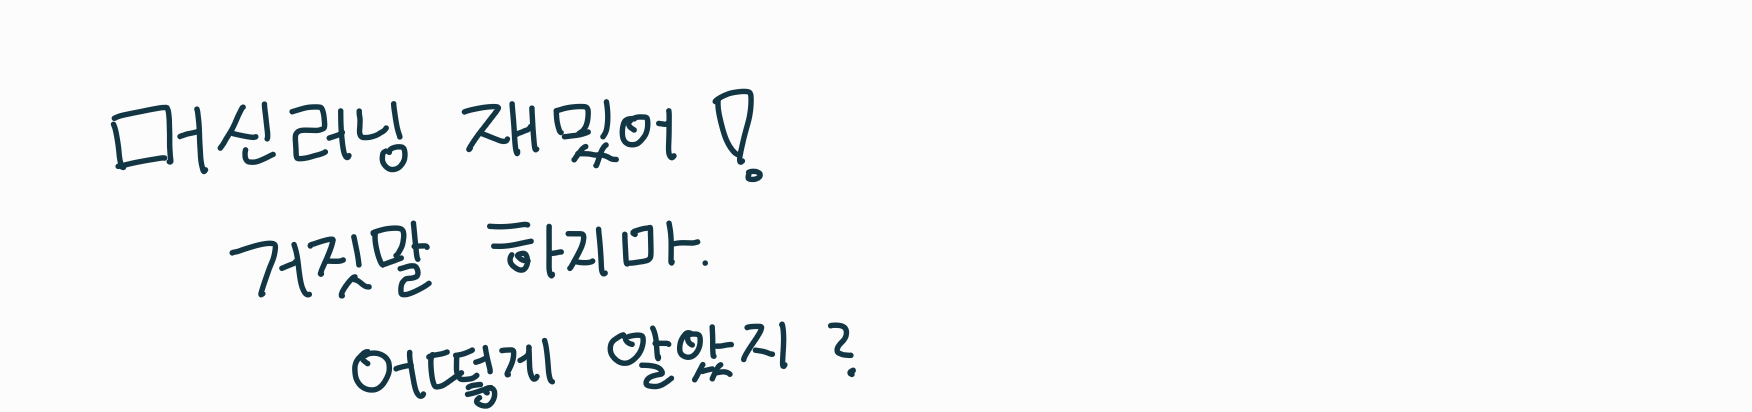

In [96]:
mingi = Image.open('민기글씨.jpg')
mingi

In [97]:
mingi = mingi.convert('L')
mingi = np.array(mingi)
mingi = cv2.adaptiveThreshold(mingi, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)
mingi = np.concatenate((get_chain_code_features(mingi)[0],get_hinge_features(mingi)),axis=0)
mingi = mingi.reshape(1,138)

In [98]:
mingi = cs.transform(mingi)

In [99]:
mingi_pred = grid.best_estimator_.predict(mingi)
mingi_pred

array([1])

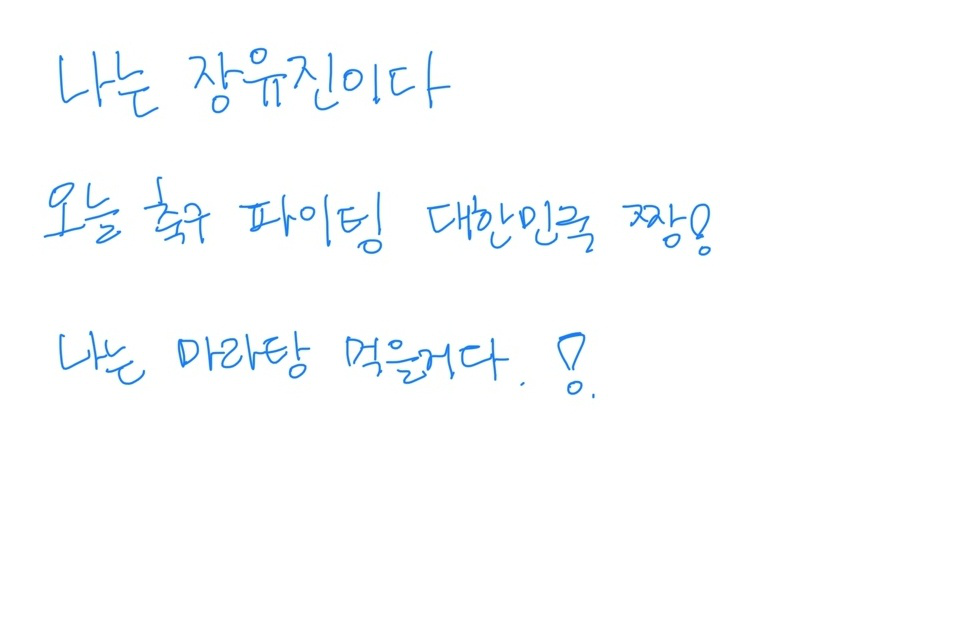

In [100]:
yujin = Image.open('유진글씨.jpg')
yujin

In [101]:
yujin = yujin.convert('L')
yujin = np.array(yujin)
yujin = cv2.adaptiveThreshold(yujin, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 199, 5)
yujin = np.concatenate((get_chain_code_features(yujin)[0],get_hinge_features(yujin)),axis=0)
yujin = yujin.reshape(1,138)
yujin = cs.transform(yujin)

In [102]:
yujin_pred = grid.best_estimator_.predict(yujin)
yujin_pred

array([1])

In [104]:
import pickle

In [105]:
with open('scaler.pkl','wb') as f:
    pickle.dump(cs,f)

In [106]:
with open('svm.pkl','wb') as f:
    pickle.dump(grid.best_estimator_,f)

rf

In [29]:
rf_param_grid = {
    'n_estimators' : [270,280,290,300],
    'max_depth' : [9,10,11,12,13],      #default : " None",
    'min_samples_leaf' : [1,2],     #default : 1
    'min_samples_split' : [2,3,4,5]  #default : 2
}

rf_clf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_clf, param_grid=rf_param_grid,scoring = 'accuracy',verbose = 1,n_jobs =-1) 
rf_grid.fit(train_x, train_y)

print(rf_grid.best_score_,rf_grid.best_params_)
rf_df = pd.DataFrame(rf_grid.cv_results_).sort_values(by='rank_test_score')
print(rf_df[['params','mean_test_score']][:5])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   53.8s finished


0.6933154235145386 {'max_depth': 13, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
                                                                                    params  \
159  {'max_depth': 13, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}   
31    {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}   
30    {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 290}   
93   {'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 280}   
26    {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 290}   

     mean_test_score  
159         0.693315  
31          0.693315  
30          0.693315  
93          0.691561  
26          0.691530  


In [45]:
rf_pred = rf_grid.best_estimator_.predict(test_x)
print('Accuracy:', accuracy_score(test_y, rf_pred)*100, '%')

Accuracy: 65.02590673575129 %


XGB

In [31]:
xgb_param={
    'n_estimators' : [290,300,310],
    'learning_rate' : [0.15,0.2,0.25],
    'max_depth' : [5,6,7,8,9],
    #'gamma' : [0],
    'colsample_bytree' : [0.7 , 0.9],
    
}
xgb_clf= xgb.XGBClassifier(random_state=42)#tree_method='gpu_hist', gpu_id=0,
xgb_grid = GridSearchCV(xgb_clf, param_grid=xgb_param,scoring = 'accuracy',verbose = 1,n_jobs =-1) 
xgb_grid.fit(train_x, train_y)

print(xgb_grid.best_score_,xgb_grid.best_params_)
xgb_df = pd.DataFrame(xgb_grid.cv_results_).sort_values(by='rank_test_score')
print(xgb_df[['params','mean_test_score']][:5])

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   41.2s finished


0.6949589127686473 {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 300}
                                                                                   params  \
25   {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 300}   
24   {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 290}   
26   {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 310}   
41  {'colsample_bytree': 0.7, 'learning_rate': 0.25, 'max_depth': 8, 'n_estimators': 310}   
40  {'colsample_bytree': 0.7, 'learning_rate': 0.25, 'max_depth': 8, 'n_estimators': 300}   

    mean_test_score  
25         0.694959  
24         0.694943  
26         0.693173  
41         0.691403  
40         0.691403  


In [46]:
xgb_pred = xgb_grid.best_estimator_.predict(test_x)
print('Accuracy:', accuracy_score(test_y, xgb_pred)*100, '%')

Accuracy: 66.32124352331607 %


Logistic regression

In [33]:
param_grid = {'penalty':['l1','l2'], 
              'C':[0.001,0.005,0.01,0.05,0.1,0.3,0.5], 
              'max_iter':[100,150,200,250,300,500]}

log_clf = LogisticRegression(random_state = 42)
log_grid = GridSearchCV(log_clf, param_grid=param_grid,scoring = 'accuracy',verbose = 1,n_jobs =-1) 
log_grid.fit(train_x, train_y)
print(log_grid.best_score_,log_grid.best_params_)
print(pd.DataFrame(log_grid.cv_results_).sort_values(by='rank_test_score')[['rank_test_score','params','mean_test_score']][:5])

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s


0.7393489254108723 {'C': 0.05, 'max_iter': 100, 'penalty': 'l2'}
    rank_test_score                                         params  \
41                1  {'C': 0.05, 'max_iter': 200, 'penalty': 'l2'}   
37                1  {'C': 0.05, 'max_iter': 100, 'penalty': 'l2'}   
39                1  {'C': 0.05, 'max_iter': 150, 'penalty': 'l2'}   
43                1  {'C': 0.05, 'max_iter': 250, 'penalty': 'l2'}   
45                1  {'C': 0.05, 'max_iter': 300, 'penalty': 'l2'}   

    mean_test_score  
41         0.739349  
37         0.739349  
39         0.739349  
43         0.739349  
45         0.739349  


[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:    0.4s finished


In [47]:
log_pred = log_grid.best_estimator_.predict(test_x)
print('Accuracy:', accuracy_score(test_y, log_pred)*100, '%')

Accuracy: 64.50777202072538 %
